### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [12]:
import oci
import pandas as pd
from ipymarkup import show_ascii_markup
from ipymarkup import show_box_markup
from ipymarkup.palette import palette, GREEN, BLUE, RED
from matplotlib import pyplot as plt

In [25]:
#agh
AllHotelData = pd.read_csv('Data.csv')
for i in range(AllHotelData['Reviews'].size):
    if(len(AllHotelData['Reviews'][i])>1000):
        AllHotelData['Reviews'][i] = (AllHotelData['Reviews'][i])[:1000]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [4]:
hotelNames = AllHotelData['name'].unique()
for hotel in hotelNames:
    print(hotel)

The Whitney Hotel
Best Western Seven Seas
Quality Suites San Diego SeaWorld Area
Hotel Abri


In [5]:
#Enter Hotel Name you want to analyze
hotelName = "Best Western Seven Seas"

In [6]:
HotelData = AllHotelData[AllHotelData['name']==hotelName]

In [7]:
# for key, value in HotelData.iteritems():
#     print(key,value[0])
Data = HotelData[['Reviews','reviews.date']].reset_index()

In [8]:
ai_client = oci.ai_language.AIServiceLanguageClient(oci.config.from_file(),
                                             service_endpoint="https://language-preprod.aiservice.us-phoenix-1.oci.oraclecloud.com")

In [9]:
data_with_result=[]
result=[]

for data in range(Data['Reviews'].size):
    try:
        detect_language_sentiments_details = oci.ai_language.models.DetectLanguageSentimentsDetails(text=Data['Reviews'][data])
        output = ai_client.detect_language_sentiments(detect_language_sentiments_details)
#         result[0] += [output.data]
#         result[1] += [Data['reviews.date'][data]]
        Dict = {'Result':output.data, 'Date':Data['reviews.date'][data]}
        result.append(Dict)
    except oci.exceptions.ServiceError as e:
        print("Something went wrong")
    

In [10]:
result[0]['Date']

'30/06/15'

In [13]:
# no_of_sentences = len(result)
no_of_sentences = 10
for sen in range(no_of_sentences):
    spans=[]
    for res in result[sen]['Result'].aspects:
        spans += [(res.offset, res.offset+res.length, res.sentiment)]
    show_box_markup(Data['Reviews'][sen], spans, palette=palette(Positvie=GREEN, Negative=RED, Neutral=BLUE))
    print()

In [14]:
# build out a data frame of all the aspects and their sentiments
no_of_sentences = len(result)
# no_of_sentences = 1
aspects=[]
for res in range(no_of_sentences):
    for i in result[res]['Result'].aspects:
        temp_aspects = (i.text, i.sentiment, i.scores, result[res]['Date'])
        aspects.append(temp_aspects)
aspects_frame = pd.DataFrame(aspects, 
                            columns=['Aspect', 'Sentiment', 'Score', 'Date'])

In [15]:
# transform and aggregate the data frame to find the top occuring Aspects and Sentiments.
top_aspects = (aspects_frame.groupby(by=['Aspect'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
no_of_top_aspects=10
top_aspects.iloc[:no_of_top_aspects,:]

,Aspect,Frequency
0,staff,53
1,room,51
2,location,37
3,rooms,35
4,pool,26
5,hotel,25
6,breakfast,22
7,grounds,21
8,Western,19
9,place,16


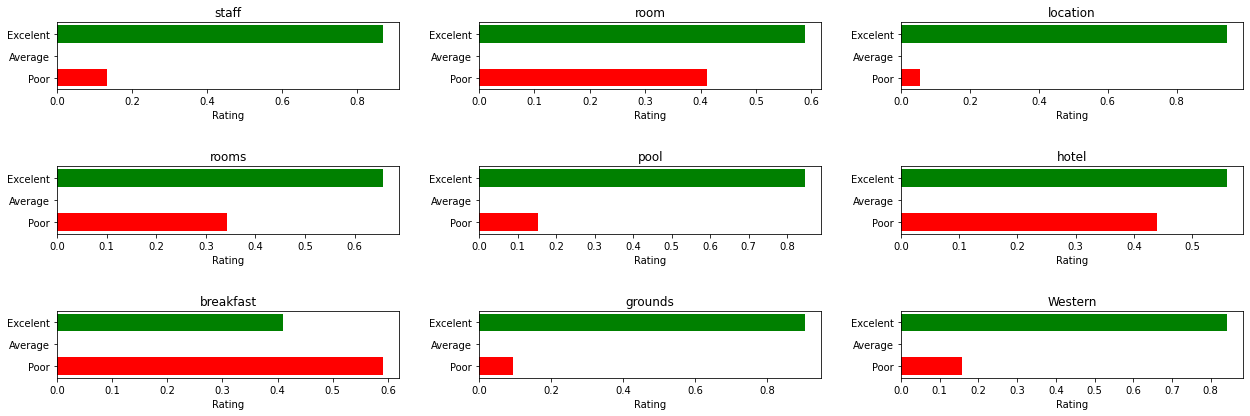

In [16]:
plt.figure(figsize=(18,10))
all_top_aspects=[]
no_of_top_aspects=9
for i in range(no_of_top_aspects):
    asp = top_aspects.iloc[i]['Aspect']
    temp = aspects_frame[aspects_frame['Aspect']==top_aspects.iloc[i]['Aspect']]
    tot_count = temp.count().Aspect
    exce = temp[temp['Sentiment']=='Positive'].count().Aspect/tot_count
    poor = temp[temp['Sentiment']=='Negative'].count().Aspect/tot_count
    avrg = temp[temp['Sentiment']=='Neutral'].count().Aspect/tot_count
    
    plt.subplot(5, 3, i+1)
    y=['Poor', 'Average', 'Excelent']
    x=[poor,avrg,exce]
    
    plt.barh(y, x, color=['red', 'grey', 'green'])

    
    # setting label of y-axis
#     plt.ylabel("pen sold")

    # setting label of x-axis
    plt.xlabel("Rating") 
    plt.title(asp)
plt.tight_layout(pad=3.0)
plt.show()

In [17]:
# transform and aggregate the data frame to find the top occuring Aspects and Sentiments.
top_aspects = (aspects_frame.groupby(by=['Aspect', 'Sentiment'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
no_of_top_aspects=10
top_aspects.iloc[:no_of_top_aspects,:]

,Aspect,Sentiment,Frequency
0,staff,Positive,46
1,location,Positive,35
2,room,Positive,30
3,rooms,Positive,23
4,pool,Positive,22
5,room,Negative,21
6,grounds,Positive,19
7,Western,Positive,16
8,hotel,Positive,14
9,parking,Positive,14


In [18]:
no_of_top_aspects=5
top_aspects_positive = top_aspects[top_aspects['Sentiment'] == 'Positive']
top_aspects_positive.iloc[:no_of_top_aspects,:]

,Aspect,Sentiment,Frequency
0,staff,Positive,46
1,location,Positive,35
2,room,Positive,30
3,rooms,Positive,23
4,pool,Positive,22


In [20]:
no_of_top_aspects=5
top_aspects_negative = top_aspects[top_aspects['Sentiment'] == 'Negative']
top_aspects_negative.iloc[:no_of_top_aspects,:]

,Aspect,Sentiment,Frequency
5,room,Negative,21
10,breakfast,Negative,13
12,rooms,Negative,12
13,hotel,Negative,11
23,bed,Negative,7


In [21]:
content_pos=''
content_neg=''
for i in top_aspects_positive['Aspect'][0:len(top_aspects_positive['Aspect'])+1]:
    content_pos = content_pos + i + " "
for i in top_aspects_negative['Aspect'][0:len(top_aspects_negative['Aspect'])+1]:
    content_neg = content_neg + i + " "

In [22]:
colour_dict = {
    'green':140,
    'blue': 220,
    'red': 20
}
def blue_fn(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(colour_dict['blue'])
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
def red_fn(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(colour_dict['red'])
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
def green_fn(word=None, font_size=None, position=None,  orientation=None, font_path=None, random_state=None):
    h = int(colour_dict['green'])
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(60, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def get_word_cloud_colour(team, text,col_fn):
#     wordcloud = WordCloud(width=1600, height=800).generate(text)
    # Open a plot of the generated image.
    wordcloud = WordCloud(width = 1600, height = 800, 
                    background_color ='white', 
#                     stopwords = stopwords,
                    color_func= col_fn,
                min_font_size = 10).generate(text) 

    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
#     plt.show()
    plt.savefig(team+'.png', facecolor='k', bbox_inches='tight')
    
def get_word_cloud(team, text):
#     wordcloud = WordCloud(width=1600, height=800).generate(text)
    # Open a plot of the generated image.
    wordcloud = WordCloud(width = 1600, height = 800, 
                    background_color ='white', 
#                     stopwords = stopwords, 
                min_font_size = 10).generate(text) 

    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
#     plt.show()
    plt.savefig(team+'.png', facecolor='k', bbox_inches='tight')

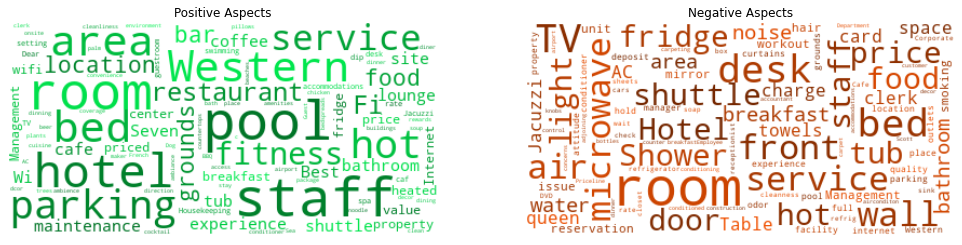

In [24]:
from wordcloud import WordCloud, STOPWORDS
wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white",color_func= green_fn).generate(content_pos)
wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white",color_func= red_fn).generate(content_neg)
plt.figure(figsize=(17,14))
# plt.figure()
plt.subplot(1, 2, 1)
plt.title("Positive Aspects")
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Negative Aspects")
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.show()

In [709]:
positive_aspects=[]
for i in range(no_of_top_aspects):
    temp = aspects_frame[aspects_frame['Aspect']==top_aspects_positive.iloc[i]['Aspect']]
    temp = temp[temp['Sentiment']==top_aspects_positive.iloc[i]['Sentiment']]
    positive_aspects.append(temp)

In [710]:
negative_aspects=[]
for i in range(no_of_top_aspects):
    temp = aspects_frame[aspects_frame['Aspect']==top_aspects_negative.iloc[i]['Aspect']]
    temp = temp[temp['Sentiment']==top_aspects_negative.iloc[i]['Sentiment']]
    negative_aspects.append(temp)

In [711]:
score_positive=[]
for i in range(5):
    temp_score=[]
    for r in positive_aspects[i]['Score']:
        temp_score.append(r['Positive'])
    score_positive.append(temp_score)

In [712]:
score_negative=[]
for i in range(5):
    temp_score=[]
    for r in negative_aspects[i]['Score']:
        temp_score.append(r['Negative'])
    score_negative.append(temp_score)

In [718]:
all_aspects=[]
for i in range(no_of_top_aspects):
    temp = aspects_frame[aspects_frame['Aspect']==top_aspects.iloc[i]['Aspect']]
#     temp = temp[temp['Sentiment']==top_aspects_positive.iloc[i]['Sentiment']]
    all_aspects.append(temp)

In [724]:
score_all=[]
for i in range(5):
    temp_score=[]
    for r in all_aspects[i]['Score']:
        temp_score.append(r['Positive'])
    score_all.append(temp_score)

In [677]:
#1. Process CSV File to get Sentiment.
#2. Group Sentiment by Property.
#3. Ask user to provide property name, sentiment type and no. of top aspects for given sentiment type.
#4. Plot the graph per aspect with Date and score.


In [678]:
len(score_positive[i])

22

In [679]:
postive_plot_value =[]
for i in range(5):
    positive_aspects[i]['Date'] = pd.to_datetime(positive_aspects[i]['Date'])
    d = {'sc': score_positive[i], 'da': positive_aspects[i]['Date']}
    df = pd.DataFrame(data=d)
    df = df.sort_values(["da"], ascending = (True))
    dict = {'Score':df['sc'], 'Date':df['da']}
    postive_plot_value.append(dict)

In [680]:

negative_plot_value =[]
for i in range(5):
    negative_aspects[i]['Date'] = pd.to_datetime(negative_aspects[i]['Date'])
    d = {'sc': score_negative[i], 'da': negative_aspects[i]['Date']}
    df = pd.DataFrame(data=d)
    df = df.sort_values(["da"], ascending = (True))
    dict = {'Score':df['sc'], 'Date':df['da']}
    negative_plot_value.append(dict)

In [726]:
plot_value =[]
for i in range(5):
    all_aspects[i]['Date'] = pd.to_datetime(all_aspects[i]['Date'])
    d = {'sc': score_all[i], 'da': all_aspects[i]['Date']}
    df = pd.DataFrame(data=d)
    df = df.sort_values(["da"], ascending = (True))
    dict = {'Score':df['sc'], 'Date':df['da']}
    plot_value.append(dict)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


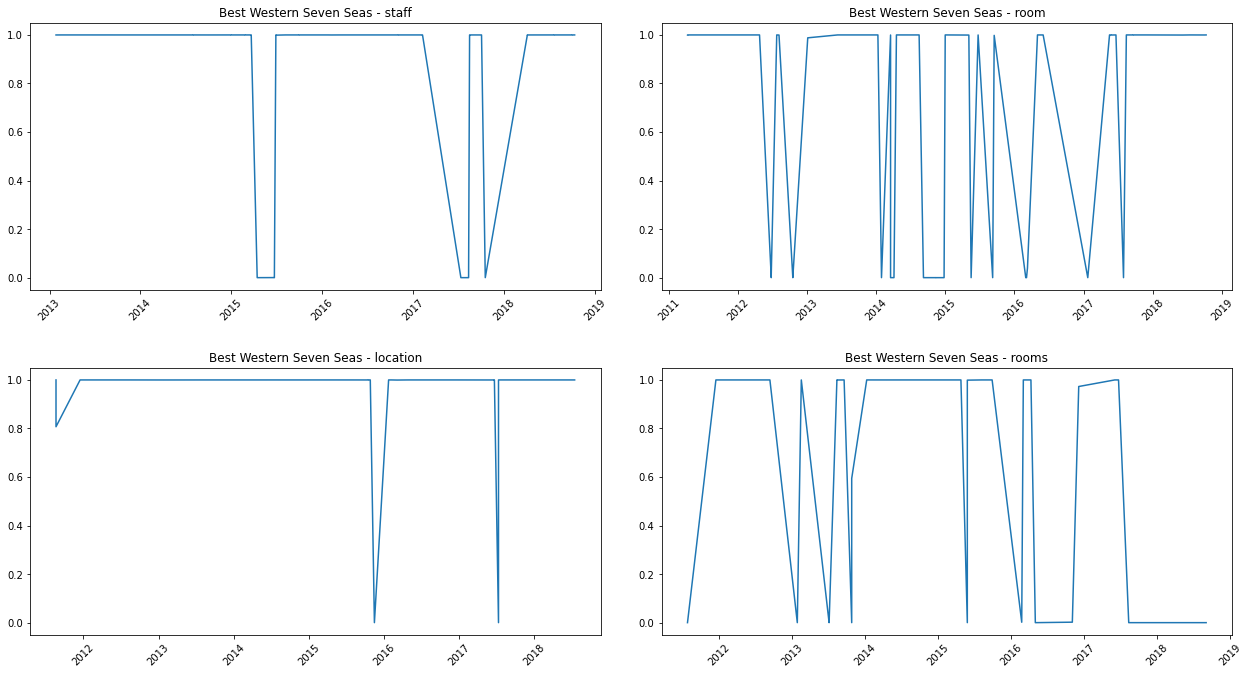

In [727]:
plt.figure(figsize=(18,10))
for i in range(4):
    x = plot_value[i]['Date']
    y = plot_value[i]['Score']
    plt.subplot(2, 2, i+1)
    plt.plot(x,y)
    plt.xticks(rotation=45)
    plt.title(hotelName+" - "+top_aspects.iloc[i]['Aspect'])
# plt.legend()
plt.xticks(rotation=45)
plt.tight_layout(pad=3.0)
plt.show()

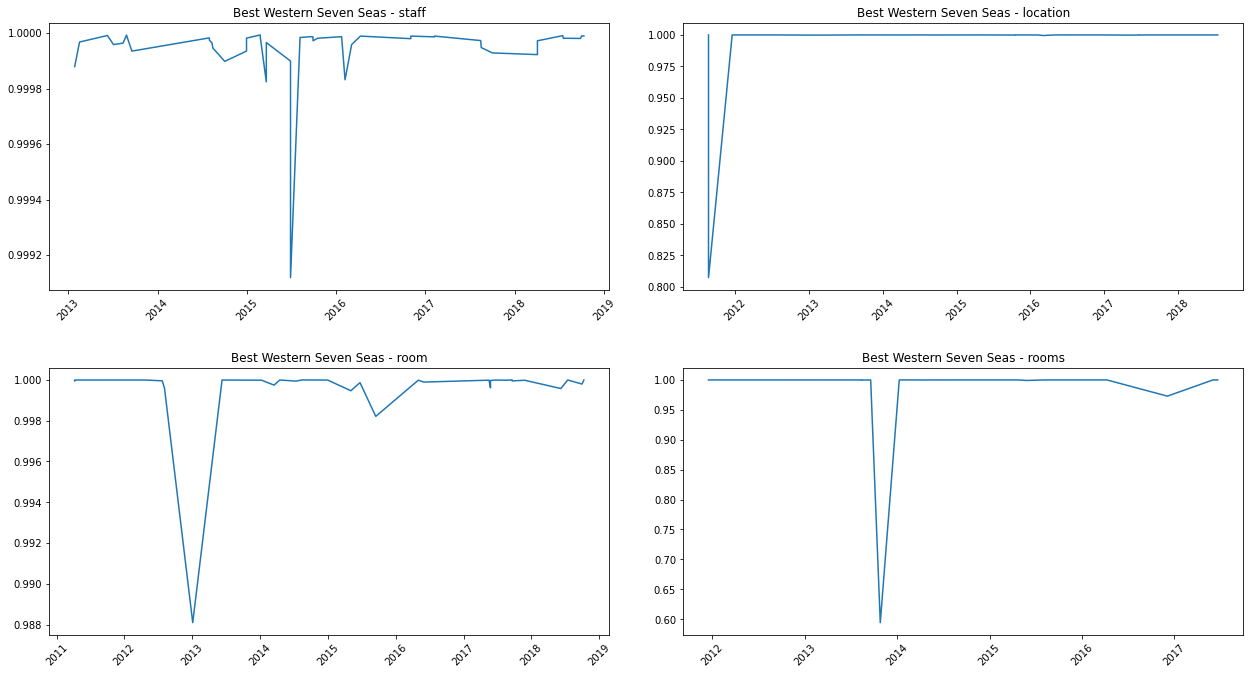

In [681]:
plt.figure(figsize=(18,10))
for i in range(4):
    x = postive_plot_value[i]['Date']
    y = postive_plot_value[i]['Score']
    plt.subplot(2, 2, i+1)
    plt.plot(x,y)
    plt.xticks(rotation=45)
    plt.title(hotelName+" - "+top_aspects_positive.iloc[i]['Aspect'])
# plt.legend()
plt.xticks(rotation=45)
plt.tight_layout(pad=3.0)
plt.show()

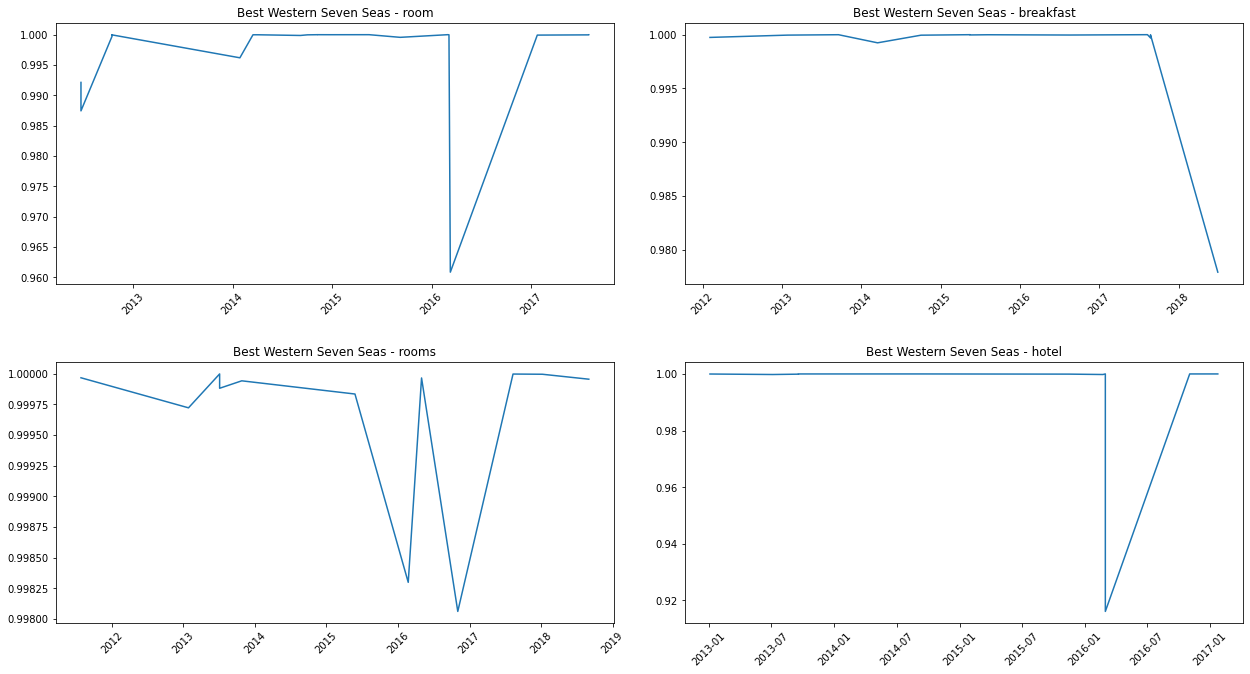

In [682]:
plt.figure(figsize=(18,10))
for i in range(4):
    x = negative_plot_value[i]['Date']
    y = negative_plot_value[i]['Score']
    plt.subplot(2, 2, i+1)
    plt.plot(x,y)
    plt.xticks(rotation=45)
    plt.title(hotelName+" - "+top_aspects_negative.iloc[i]['Aspect'])

# plt.figure(figsize=(20,10))
# plt.plot(positive_aspects[0]['Date'], score[0], label = top_aspects_positive.iloc[0]['Aspect'], color='lightcoral')
# plt.plot(positive_aspects[1]['Date'], score[1], label = top_aspects_positive.iloc[1]['Aspect'], color='green')
# plt.plot(positive_aspects[2]['Date'], score[2], label = top_aspects_positive.iloc[2]['Aspect'], color='blue')
# plt.plot(positive_aspects[3]['Date'], score[3], label = top_aspects_positive.iloc[3]['Aspect'], color='blue')
# plt.plot(positive_aspects[4]['Date'], score[4], label = top_aspects_positive.iloc[4]['Aspect'], color='black')
# plt.legend()
plt.xticks(rotation=45)
plt.tight_layout(pad=3.0)
plt.show()

In [729]:
# transform and aggregate the data frame to find the top occuring sentiments
top_aspects = (aspects_frame.groupby(by=['Sentiment'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))

no_of_top_aspects = top_aspects['Sentiment'].size
top_aspects.iloc[:no_of_top_aspects,:]

,Sentiment,Frequency
0,Positive,608
1,Negative,386


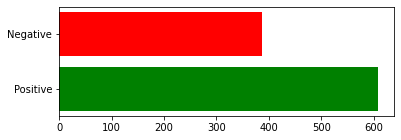

In [730]:
# Horizontal Bar Plot
fig = plt.figure(figsize =(6, 2))
plt.barh(top_aspects['Sentiment'], top_aspects['Frequency'], color=['green','red'])
# Show Plot
plt.show()